In [ ]:
%load_ext autoreload
%autoreload 2
    
import os, sys
#PWD = os.getenv('PWD')
PWD = '/Users/chris/Documents/lab/emAnalysis/backend/server'

PROJ_MISSING_MSG = """Set an enviroment variable:\n
`DJANGO_PROJECT=your_project_name`\n
or call:\n
`init_django(your_project_name)`
"""

def init_django(project_name=None):
    os.chdir(PWD)
    project_name = project_name or os.environ.get('DJANGO_PROJECT') or None
    if project_name == None:
        raise Exception(PROJ_MISSING_MSG)
    sys.path.insert(0, os.getenv('PWD'))
    os.environ.setdefault('DJANGO_SETTINGS_MODULE', f'{project_name}.settings')
    os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
    import django
    django.setup()

init_django("server")
from django.conf import settings
media_root = settings.MEDIA_ROOT
import numpy as np
import os
from matplotlib import pyplot as plt
import functools
import math
import sims
import copy
import cv2
import os
from pathlib import Path
import numpy as np
from skimage.measure import regionprops
from scipy import spatial
import pickle
from matplotlib.figure import Figure
import pyvips
from core.models import Canvas
from mims.models import MIMSImage, MIMSImageSet
from PIL import Image
from scipy.ndimage import rotate
import pprint
import sims
import SimpleITK as sitk
import tifffile

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
mims = MIMSImage.objects.filter(file__isnull=False).select_related('canvas')
mims = [m for m in mims if m.file.name.endswith('85_mosaic_4.im')][0]


In [3]:
def show_registration_qc(mims_image, isotope_name: str = "32S"):
    """
    Quick-look QC plot for a registered NanoSIMS stack.

    Layout
    ------
        Row 1 (raw images):      [EM]  [unwarped isotope]  [ ]  [ ]
        Row 2 (vector graphics): [EM shapes]  [MIMS shapes ∎ post-affine]
                                  [Overlay]   [MIMS shapes ∎ post-affine + TPS]

    Parameters
    ----------
    mims_image : MIMSImage  (Django instance)
    isotope_name : str, optional
        Isotope slice to display.  Defaults to "32S".
    """
    # ------------------------------------------------------------------
    #  Imports
    # ------------------------------------------------------------------
    import json, os
    from pathlib import Path

    import numpy as np
    import tifffile, PIL.Image as pil
    import matplotlib.pyplot as plt
    import SimpleITK as sitk

    from mims.models import MimsTiffImage
    from mims.services.orient_images import get_points_transform
    from mims.services.unwarp2 import polygon_centroid

    # ------------------------------------------------------------------
    #  File locations & image arrays
    # ------------------------------------------------------------------
    reg_loc = Path(mims_image.file.path).with_suffix("") / "registration"

    # isotope image (after full warp, written by make_unwarp_images)
    mti = MimsTiffImage.objects.filter(
        mims_image=mims_image, name=isotope_name
    ).first()
    if not mti:
        raise FileNotFoundError(f"No stored tiff image for isotope {isotope_name}")

    iso_arr = np.array(pil.open(mti.image.path))

    # EM crop corresponding to the registration bbox
    em_full = tifffile.imread(mims_image.canvas.images.first().file)
    y0, x0 = [mti.registration_bbox[0][1], mti.registration_bbox[0][0]]
    y1, x1 = [mti.registration_bbox[1][1], mti.registration_bbox[1][0]]
    em_arr = em_full[int(y0):int(y1), int(x0):int(x1)]

    # ------------------------------------------------------------------
    #  Shapes from JSON
    # ------------------------------------------------------------------
    with open(reg_loc / "reg_shapes.json") as f:
        shapes_json = json.load(f)
    em_shapes   = [np.asarray(s, float) for s in shapes_json["em_shapes"]]
    mims_shapes = [np.asarray(s, float) for s in shapes_json["mims_shapes"]]

    # ------------------------------------------------------------------
    #  Coarse (similarity) alignment
    # ------------------------------------------------------------------
    em_cent   = np.array([polygon_centroid(p) for p in em_shapes])
    mims_cent = np.array([polygon_centroid(p) for p in mims_shapes])
    tform, needs_flip, _ = get_points_transform(
        mims_image.image_set, mims_cent, em_cent
    )

    if needs_flip:
        w_orig = iso_arr.shape[1]
        mims_shapes = [
            np.column_stack([(w_orig - 1) - p[:, 0], p[:, 1]]) for p in mims_shapes
        ]

    mims_shapes_affine = [tform(p) for p in mims_shapes]

    # ------------------------------------------------------------------
    #  Thin-plate-spline warp
    # ------------------------------------------------------------------
    tps_path = reg_loc / "mims_tps_transform.tfm"
    print(reg_loc)
    if tps_path.exists():
        tps = sitk.ReadTransform(str(tps_path))
        # apply TPS to every vertex
        mims_shapes_full = [
            np.array([tps.TransformPoint(tuple(pt)) for pt in shp]) for shp in mims_shapes_affine
        ]
    else:
        # fallback – TPS not present
        mims_shapes_full = mims_shapes_affine

    # ------------------------------------------------------------------
    #  Plotting
    # ------------------------------------------------------------------
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))

    # Row 1
    axs[0, 0].imshow(em_arr, cmap="gray")
    axs[0, 0].set_title("EM")
    axs[0, 1].imshow(iso_arr, cmap="inferno")
    axs[0, 1].set_title(f"{isotope_name} unwarped")
    for ax in axs[0, 2:]:
        ax.axis("off")

    # Row 2 – panel 0: EM shapes
    for shp in em_shapes:
        axs[1, 0].plot(shp[:, 0], shp[:, 1], color="red")
    axs[1, 0].invert_yaxis(); axs[1, 0].set_aspect("equal")
    axs[1, 0].set_title("EM shapes"); axs[1, 0].axis("off")

    # panel 1: MIMS shapes after affine
    for shp in mims_shapes_affine:
        axs[1, 1].plot(shp[:, 0], shp[:, 1], color="blue")
    axs[1, 1].invert_yaxis(); axs[1, 1].set_aspect("equal")
    axs[1, 1].set_title("MIMS shapes (post-affine)"); axs[1, 1].axis("off")

    # panel 2: overlay of EM vs post-affine MIMS
    for shp in em_shapes:
        axs[1, 2].plot(shp[:, 0], shp[:, 1], color="red")
    for shp in mims_shapes_affine:
        axs[1, 2].plot(shp[:, 0], shp[:, 1], color="cyan")
    axs[1, 2].invert_yaxis(); axs[1, 2].set_aspect("equal")
    axs[1, 2].set_title("Overlay (affine)"); axs[1, 2].axis("off")

    # panel 3: MIMS shapes after full TPS warp
    for shp in em_shapes:
        axs[1, 3].plot(shp[:, 0], shp[:, 1], color="red")
    for shp in mims_shapes_full:
        axs[1, 3].plot(shp[:, 0], shp[:, 1], color="lime")
    axs[1, 3].invert_yaxis(); axs[1, 3].set_aspect("equal")
    axs[1, 3].set_title("Overlay MIMS shapes (post-TPS)"); axs[1, 3].axis("off")

    plt.tight_layout()
    plt.show()
    return fig


In [49]:
import numpy as np
import matplotlib.pyplot as plt

def plot_point_sets(ptset1, ptset2,
                    titles=("EM (reference)", "MIMS (moving)", "Overlay"),
                    colors=("tab:blue", "tab:orange"),
                    annotate=False):
    """
    Visualise two matched 2-D landmark sets.

    Parameters
    ----------
    ptset1, ptset2 : (N, 2)-array-like
        Coordinates of the first and second point clouds.
        They need not have the same length, but order should be preserved
        if you want the overlay to make sense.
    titles : 3-tuple of str
        Figure titles for the three panels.
    colors : 2-tuple of valid Matplotlib colours
        Scatter colours for the two data sets.
    annotate : bool, default False
        If True, index-labels each point.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure containing the three side-by-side subplots.
    axes : np.ndarray of matplotlib.axes.Axes
        The array of subplot axes (shape = (3,)).
    """
    p1 = np.asarray(ptset1, dtype=float)
    p2 = np.asarray(ptset2, dtype=float)

    # Determine common limits so all three panels share the same viewbox
    all_pts = np.vstack([p1, p2])
    span = np.ptp(all_pts, axis=0)              # <-- np.ptp, not ndarray.ptp
    pad  = 0.05 * np.where(span == 0, 1.0, span)  # handle degenerate axis

    xlim = (all_pts[:, 0].min() - pad[0], all_pts[:, 0].max() + pad[0])
    ylim = (all_pts[:, 1].min() - pad[1], all_pts[:, 1].max() + pad[1])

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

    def _scatter(ax, pts, colour, title):
        ax.scatter(pts[:, 0], pts[:, 1],
                   s=40, c=colour, ec="k", linewidth=0.5, zorder=3)
        if annotate:
            for i, (x, y) in enumerate(pts):
                ax.text(x, y, f"{i}", fontsize=8,
                        ha="right", va="bottom", zorder=4)
        ax.set_title(title, fontsize=12)
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.grid(True, linestyle=":", linewidth=0.5)

    # Left panel – reference
    _scatter(axes[0], p1, colors[0], titles[0])

    # Middle panel – moving / transformed
    _scatter(axes[1], p2, colors[1], titles[1])

    # Right panel – overlay
    _scatter(axes[2], p1, colors[0], titles[2])
    axes[2].scatter(p2[:, 0], p2[:, 1],
                    s=40, c=colors[1], ec="k", linewidth=0.5, marker="s", zorder=3)
    if annotate:
        for i, (x, y) in enumerate(p2):
            axes[2].text(x, y, f"{i}", fontsize=8,
                         ha="left", va="top", zorder=4)

    return fig, axes


(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: title={'center': 'EM (reference)'}>,
        <Axes: title={'center': 'MIMS (moving)'}>,
        <Axes: title={'center': 'Overlay'}>], dtype=object))

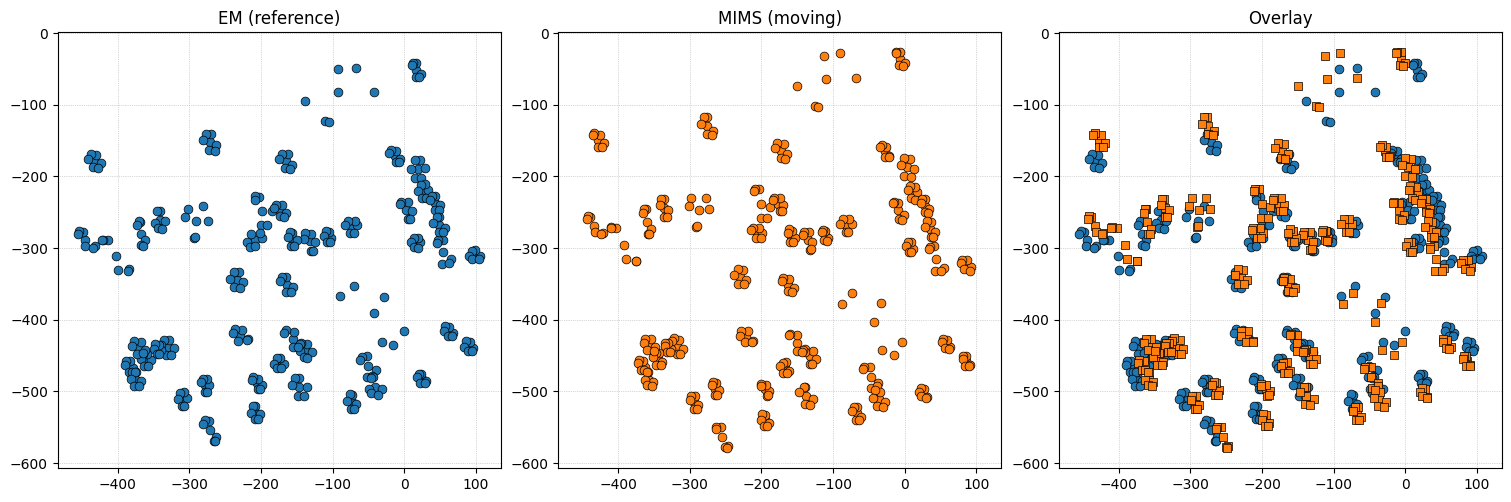

In [86]:
plot_point_sets(em_pts, mims_pts, annotate=False)

In [50]:
#show_registration_qc(mims)

import json
import math
import time
from django.shortcuts import get_object_or_404

# Assume these are correctly implemented and imported
# from mims.services.image_utils import image_from_im_file
# from mims.services.orient_images import get_points_transform
import tifffile
from mims.services.unwarp2 import make_unwarp_transform, make_unwarp_images
from mims.services.image_utils import image_from_im_file
from mims.services.orient_images import get_points_transform
from skimage.transform import estimate_transform, SimilarityTransform, AffineTransform
from skimage.draw import polygon
from skimage.transform import warp
import sims
from mims.models import MIMSImage
import os
from pathlib import Path
import numpy as np
from mims.services.registration_utils import assemble_landmarks
from mims.services.register3 import load_shapes, load_mims_data, get_points_transform, polygon_centroid

In [117]:
from skimage.transform import ThinPlateSplineTransform, warp
def radial_spokes(shape: np.ndarray, n_spokes: int = 6) -> np.ndarray:
    """
    Return the  `n_spokes`  vertices that lie furthest from the centroid
    in n evenly spaced angular directions (0-360°).
    """
    c = polygon_centroid(shape)
    rel = shape - c
    angles = np.linspace(0, 2 * np.pi, n_spokes, endpoint=False)
    v = np.stack([np.cos(angles), np.sin(angles)], axis=1)  # (n,2)

    # project every vertex onto each spoke direction, pick the farthest
    proj = rel @ v.T  # (Nv, n_spokes)
    idx = np.argmax(proj, axis=0)  # indices of farthest vertices
    return shape[idx]  # (n_spokes, 2)

def register_images3_test(mims_image_obj_id, shrink_em=True):
    start_time = time.time()
    # --- Get MIMS Object and Paths ---
    try:
        mims_image = get_object_or_404(MIMSImage, pk=mims_image_obj_id)
    except Exception as e:
        raise ValueError(f"Could not find MIMSImage ID {mims_image_obj_id}: {e}") from e

    if (
        not mims_image.file
        or not hasattr(mims_image.file, "path")
        or not mims_image.file.path
    ):
        raise ValueError(f"MIMSImage {mims_image_obj_id} lacks a valid file path.")
    mims_path = Path(mims_image.file.path)
    if not mims_path.exists():
        raise FileNotFoundError(f"MIMS file not found: {mims_path}")

    reg_loc = mims_path.parent / mims_path.stem / "registration"
    os.makedirs(reg_loc, exist_ok=True)

    json_shapes = load_shapes(reg_loc / "reg_shapes.json")
    em_shapes = [np.array(s, dtype=float) for s in json_shapes.get("em_shapes", [])]
    mims_shapes = [np.array(s, dtype=float) for s in json_shapes.get("mims_shapes", [])]
    em_shapes = [
        s for s in em_shapes if s.ndim == 2 and s.shape[0] >= 3 and s.shape[1] >= 2
    ]
    mims_shapes = [
        s for s in mims_shapes if s.ndim == 2 and s.shape[0] >= 3 and s.shape[1] >= 2
    ]

    if not mims_shapes or not em_shapes:
        raise ValueError("No valid MIMS or EM shapes found.")
    if len(mims_shapes) != len(em_shapes):
        raise ValueError("MIMS and EM shape lists differ in length.")

    em_centroids = np.array([polygon_centroid(ep) for ep in em_shapes])
    mims_centroids = np.array([polygon_centroid(mp) for mp in mims_shapes])

    # --- Get Initial Transform ---
    image_view_set = mims_image.image_set

    selected_tform, needs_flip, _ = get_points_transform(
        image_view_set, mims_centroids, em_centroids
    )
    isotope_names, (h_mims, w_mims), mims_data_cube = load_mims_data(mims_image)

    # cache for next time
    mims_image.affine_tform = selected_tform.params.tolist()
    mims_image.flip = needs_flip
    mims_image.save(update_fields=["affine_tform", "flip"])
    if needs_flip:
        mims_shapes_flipped = []
        for mims_shape in mims_shapes:
            mims_shapes_flipped.append([[(w_mims - 1) - pt[0], pt[1]] for pt in mims_shape])
        mims_shapes = mims_shapes_flipped

    base_transform = selected_tform

    # --- Load ALL MIMS Isotope Data ---
    print("Loading all required isotope data...")
    isotope_names, (h_mims, w_mims), mims_data_cube = load_mims_data(mims_image)

    # Apply the rotation ONLY to the MIMS points to bring them into the EM orientation
    theta = base_transform.rotation
    rot_only = AffineTransform(rotation=theta)
    new_bbox = rot_only(
        [[0, 0], [w_mims - 1, 0], [w_mims - 1, h_mims - 1], [0, h_mims - 1]]
    )
    min_x = np.min(new_bbox[:, 0])
    min_y = np.min(new_bbox[:, 1])
    max_x = np.max(new_bbox[:, 0])
    max_y = np.max(new_bbox[:, 1])
    new_bbox_width = math.ceil(max_x - min_x)
    new_bbox_height = math.ceil(max_y - min_y)
    mims_shapes_rot = [rot_only(mims_shape) for mims_shape in mims_shapes]

    # And scale down and translate the EM image made from it's shapes
    scale_and_translate = AffineTransform(scale=1/base_transform.scale, translation=(-base_transform.translation[0]/base_transform.scale, -base_transform.translation[1]/base_transform.scale))
    em_small = [scale_and_translate(em_shape) for em_shape in em_shapes]

    # Then get the landmark points for TPS
    padding = int(max(new_bbox_width, new_bbox_height) * 0.1)
    em_pts, mims_pts = [], []
    for em, mi in zip(em_small, mims_shapes_rot):
        em_pts.append(polygon_centroid(em))
        mims_pts.append(polygon_centroid(mi))
        em_pts.extend(radial_spokes(em))
        mims_pts.extend(radial_spokes(mi))
    for pt in em_pts:
        pt[0] += padding
        pt[1] += padding
    for pt in mims_pts:
        pt[0] += padding
        pt[1] += padding
    em_pts = np.asarray(em_pts)
    mims_pts = np.asarray(mims_pts)
    tps = ThinPlateSplineTransform()
    tps.estimate(em_pts, mims_pts)
    
    # Then load a MIMS isotope image, rotate it, TPS it, and then translate and upscale it
    s32 = image_from_im_file(mims_image.file.path, "32S")
    if mims_image.flip:
        print("flipping")
        s32_flipped = s32.copy()
        max_x_mims = s32_flipped.shape[1]
        s32_flipped[:, 0] = -s32_flipped[:, 0]
        s32_flipped[:, 0] += abs(max_x_mims)
        s32 = s32_flipped
    # Pad it by min_x, and min_y
    print("original", s32.shape, np.min(s32), np.max(s32), np.count_nonzero(s32)/s32.size)
    rot_padding = AffineTransform(translation=(-min_x+padding, -min_y+padding), rotation=theta)
    s32_rot = warp(s32, rot_padding.inverse, output_shape=(new_bbox_height + padding*3, new_bbox_width + padding*3))
    print("rot", s32_rot.shape, np.min(s32_rot), np.max(s32_rot), np.count_nonzero(s32_rot)/s32_rot.size)
    s32_corr = warp(s32_rot, tps, output_shape=(new_bbox_height+padding*3, new_bbox_width+padding*3))
    print("corr", s32_corr.shape, np.min(s32_corr), np.max(s32_corr), np.count_nonzero(s32_corr)/s32_corr.size)
    # Then scale it up and translate it by the base transform
    scale_only = AffineTransform(scale=1/base_transform.scale)
    s32_corr_scaled = warp(s32_corr, scale_only, output_shape=(math.ceil(s32_corr.shape[0]*base_transform.scale), math.ceil(s32_corr.shape[1]*base_transform.scale)))
    print("scaled", s32_corr_scaled.shape, np.min(s32_corr_scaled), np.max(s32_corr_scaled), np.count_nonzero(s32_corr_scaled)/s32_corr_scaled.size)
    # Then get the EM image at the right coordinates
    em = tifffile.imread(mims_image.canvas.images.first().file.path)
    print("base_transform.translation", base_transform.translation, padding*base_transform.scale)
    start_y = int(base_transform.translation[1] + (min_y+padding)*base_transform.scale)
    start_x = int(base_transform.translation[0] + (min_x+padding)*base_transform.scale)
    print("start_y", start_y, "start_x", start_x, base_transform.translation, s32_corr_scaled.shape)
    em_crop = em[start_y:start_y+s32_corr_scaled.shape[0], start_x:start_x+s32_corr_scaled.shape[1]]
    # Matplotlib the pre tps and post tps side by side
    fig, axes = plt.subplots(1, 4, figsize=(10, 5))
    axes[0].imshow(s32_rot, cmap="gray")
    axes[0].set_title("Original")
    axes[1].imshow(s32_corr, cmap="gray")
    axes[1].set_title("Post TPS")
    axes[2].imshow(s32_corr_scaled, cmap="gray")
    axes[2].set_title("Scaled")
    axes[3].imshow(em_crop, cmap="gray")
    axes[3].set_title("EM Crop")
    plt.show()
    return (em_pts, mims_pts)


Base MIMS shape from 14N 12C: (512, 512)
Loaded data cube shape: (6, 512, 512)
Loading all required isotope data...
Base MIMS shape from 14N 12C: (512, 512)
Loaded data cube shape: (6, 512, 512)
original (512, 512) 0 512 0.9880256652832031
rot (823, 823) 0.0 0.0077941814916504685 0.38831498429862005
corr (823, 823) 0.0 0.0075303793885738044 0.4028633057199677
scaled (13004, 13004) 0.0 0.007324091641654131 0.404875493909027
base_transform.translation [30439.81614396 20121.64942098] 995.4416782560255
start_y 11104 start_x 23684 [30439.81614396 20121.64942098] (13004, 13004)


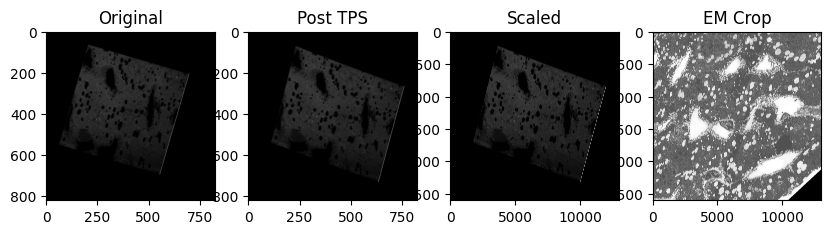

(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: title={'center': 'EM (reference)'}>,
        <Axes: title={'center': 'MIMS (moving)'}>,
        <Axes: title={'center': 'Overlay'}>], dtype=object))

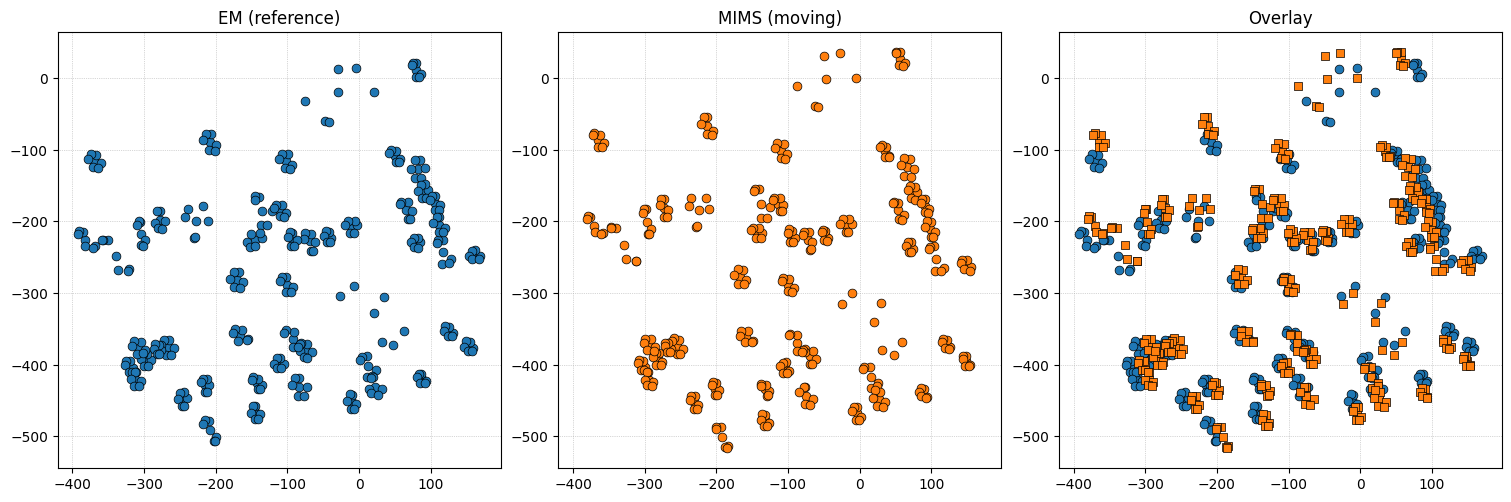

In [118]:
em_pts, mims_pts = register_images3_test(mims.id)
plot_point_sets(em_pts, mims_pts, annotate=False)
